# Detecting levels

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


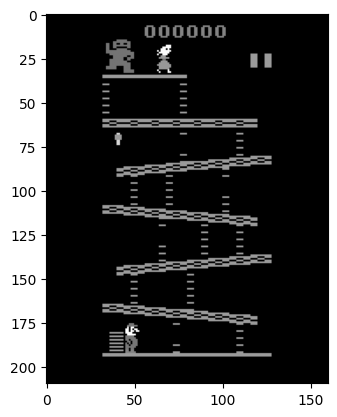

In [1]:
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt
from PIL import Image
import cv2

gym.register_envs(ale_py)

env = gym.make("ALE/DonkeyKong-v5", render_mode="rgb_array")

obs, info = env.reset()
gray_obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
plt.imshow(gray_obs, cmap="gray")
plt.show()

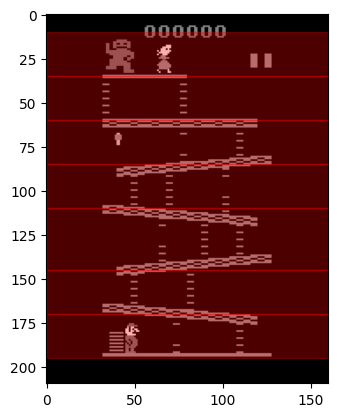

In [89]:
levels_height = [25, 25, 35, 25, 25, 25, 25]
levels_y_lst = [170, 145, 110, 85, 60, 35, 10]

# plot image with transparent rectangles on each level with different colors
fig, ax = plt.subplots()
for i, y in enumerate(levels_y_lst):
	rect = plt.Rectangle((0, y), 256, levels_height[i], color="red", alpha=0.3)
	ax.add_patch(rect)
plt.imshow(gray_obs, cmap="gray")
plt.show()

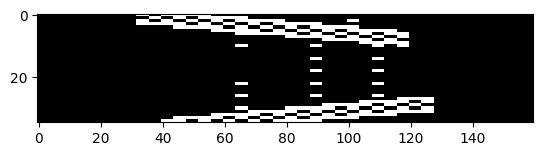

In [90]:
# crop
temp_crop = gray_obs[110:145, :]
plt.imshow(temp_crop, cmap="gray")
plt.show()

(35, 6)


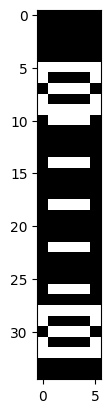

In [91]:
# crop
temp_crop = gray_obs[110:145, 107:113]
print(temp_crop.shape)
plt.imshow(temp_crop, cmap="gray")
plt.show()

(25, 7)


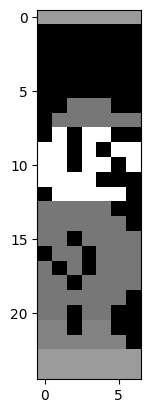

In [92]:
# crop
temp_crop = gray_obs[170:195, 45:52]
print(temp_crop.shape)
plt.imshow(temp_crop, cmap="gray")
plt.show()

# Detecting ladders positions

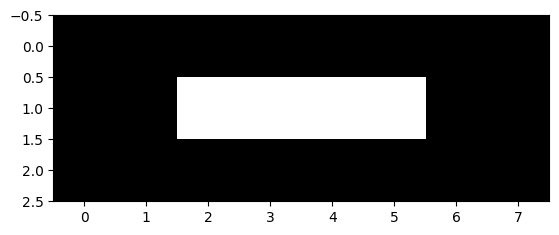

In [93]:
import numpy as np

# ladder part template
# ladder part is 4x1 pixels
w, h = 8, 3
ladder_part = np.zeros((h, w))
ladder_part[1:-1, 2:-2] = 1
plt.imshow(ladder_part, cmap="gray")
plt.show()

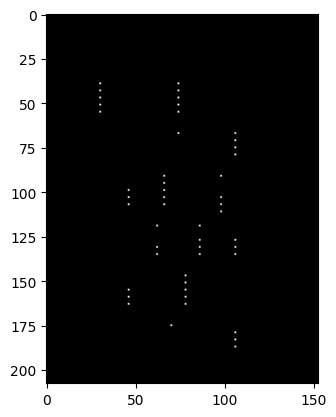

In [94]:
# perform template matching
template_matching_res = cv2.matchTemplate(
	gray_obs.astype(np.float32),
	ladder_part.astype(np.float32),
	cv2.TM_CCOEFF_NORMED
)
# filter
threshold = np.max(template_matching_res)
template_matching_res[template_matching_res < threshold] = 0
plt.imshow(template_matching_res, cmap="gray")
plt.show()

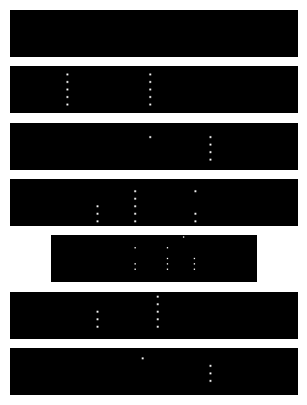

In [95]:
# segment the image into levels
levels_template_matching_res = []
for i, y in enumerate(levels_y_lst):
	levels_template_matching_res.append(template_matching_res[y:y+levels_height[i], :])
fig, axs = plt.subplots(len(levels_template_matching_res), 1, figsize=(5, 5))
for i, res in enumerate(levels_template_matching_res[::-1]):
	axs[i].imshow(res, cmap="gray")
	axs[i].axis("off")
plt.show()

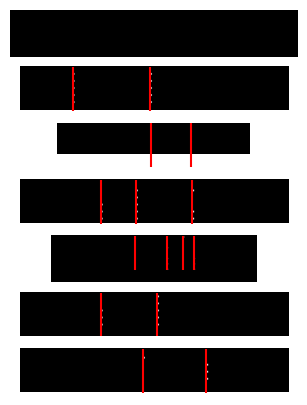

In [96]:
# detect y coordinates that have white pixels
levels_x_coords = []
for i, y in enumerate(levels_y_lst):
	levels_x_coords.append(
		np.unique(np.where(levels_template_matching_res[i] > 0)[1])
	)
fig, axs = plt.subplots(len(levels_x_coords), 1, figsize=(5, 5))
for i, x_coords in enumerate(levels_x_coords[::-1]):
	# draw a vertical line at each x_coords
	axs[i].imshow(levels_template_matching_res[len(levels_template_matching_res)-i-1], cmap="gray")
	axs[i].vlines(x_coords, 0, levels_height[i], color="red")
	axs[i].axis("off")
plt.show()

In [97]:
levels_x_coords

[array([ 70, 106]),
 array([46, 78]),
 array([ 62,  86,  98, 106]),
 array([46, 66, 98]),
 array([ 74, 106]),
 array([30, 74]),
 array([], dtype=int64)]

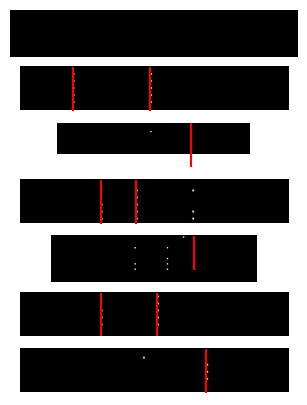

In [98]:
# keep only the ones that their points are all at same distance from each other (use diff)
filtered_levels_x_coords = []
for l, (x_coords, tm_res) in enumerate(zip(levels_x_coords, levels_template_matching_res)):
	filtered_levels_x_coords.append([])
	for x in x_coords:
		x_slice = tm_res[:, x]
		distances = np.diff(np.where(x_slice > 0)[0])
		if len(set(distances)) == 1: # all distances are the same
			filtered_levels_x_coords[l].append(x)

# plot the filtered x_coords
fig, axs = plt.subplots(len(filtered_levels_x_coords), 1, figsize=(5, 5))
for i, x_coords in enumerate(filtered_levels_x_coords[::-1]):
	# draw a vertical line at each x_coords
	axs[i].imshow(levels_template_matching_res[len(levels_template_matching_res)-i-1], cmap="gray")
	axs[i].vlines(x_coords, 0, levels_height[i], color="red")
	axs[i].axis("off")
plt.show()

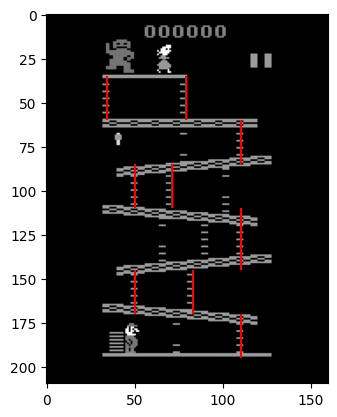

In [99]:
# translate this positions to the original image (gray_obs)
# get the x coordinates of the ladders in the original image
ladders_x_coords = []
for i, x_coords in enumerate(filtered_levels_x_coords[::-1]):
	ladders_x_coords.append(x_coords + np.arange(len(x_coords)))

# sort from bottom to top
ladders_x_coords = ladders_x_coords[::-1]
# correct x coordinates (template matching did top left corner)
ladders_x_coords = [x + ladder_part.shape[1]//2 for x in ladders_x_coords]

# plot the ladders in the original image
fig, ax = plt.subplots()
ax.imshow(gray_obs, cmap="gray")
for i, x_coords in enumerate(ladders_x_coords):
	ax.vlines(x_coords, levels_y_lst[i], levels_y_lst[i]+levels_height[i], color="red")
plt.show()

In [100]:
ladders_x_coords

[array([110]),
 array([50, 83]),
 array([110]),
 array([50, 71]),
 array([110]),
 array([34, 79]),
 array([], dtype=float64)]

# Detect level of Mario

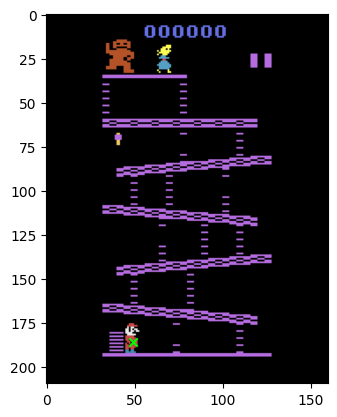

In [101]:
def get_agent_position(obs):
	redness = obs[:, :, 0].astype(np.int16) - np.maximum(obs[:, :, 1], obs[:, :, 2]).astype(np.int16)
	max_redness = np.max(redness)
	most_reddish = (redness == max_redness)
	kernel = np.ones((2, 2), np.uint8)
	most_reddish = cv2.morphologyEx(most_reddish.astype(np.uint8), cv2.MORPH_OPEN, kernel)
	center_of_mass = np.argwhere(most_reddish)
	center_of_mass = np.mean(center_of_mass, axis=0)
	return center_of_mass

center_of_mass = get_agent_position(obs)
plt.imshow(obs)
plt.scatter(center_of_mass[1], center_of_mass[0], color="lime", marker="x")
plt.show()

In [102]:
# center_of_mass = [120, 100]
center_of_mass

array([186.,  49.])

In [109]:
def get_level(obs, center_of_mass):
    levels_height = [25, 25, 35, 25, 25, 25, 25]
    levels_y_lst = [170, 145, 110, 85, 60, 35, 10]
    for i, y in enumerate(levels_y_lst):
        if center_of_mass[0] > y:
            return i
    return len(levels_y_lst)

level = get_level(obs, center_of_mass)
print(level)

0


In [110]:
[list([int(j) for j in i]) for i in ladders_x_coords]

[[110], [50, 83], [110], [50, 71], [110], [34, 79], []]

In [118]:
def get_ladders_from_level(obs, level):
    ladders_x_coords = [[110], [50, 83], [110], [50, 71], [110], [34, 79], []]
    return ladders_x_coords[level]

ladders_from_level = get_ladders_from_level(obs, level)
print(ladders_from_level)

[110]


# Distance from ladders to Mario

In [119]:
def get_distance_to_ladders(obs, center_of_mass, ladders_x_coords):
    distance = []
    for ladder in ladders_x_coords:
        distance.append(abs(center_of_mass[1] - ladder))
    return distance

distance_to_ladders = get_distance_to_ladders(obs, center_of_mass, ladders_from_level)
print(distance_to_ladders)

[np.float64(61.0)]


/tmp/ipykernel_379175/1996822807.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


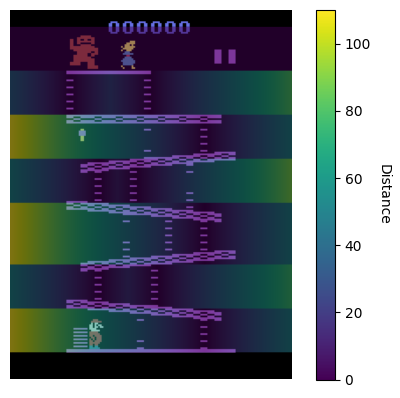

In [126]:
import seaborn as sns

levels_height = [25, 25, 35, 25, 25, 25, 25]
levels_y_lst = [170, 145, 110, 85, 60, 35, 10]
# ladders_x_coords should match the levels order, assumed defined elsewhere
ladders_x_coords = [[110], [50, 83], [110], [50, 71], [110], [34, 79], []]

# We'll handle the last empty level gracefully.
fig, ax = plt.subplots(figsize=(6.4, 4.8))
ax.imshow(obs)

# Prepare the overlay for distances: set all as np.nan for transparency
overlay = np.full((obs.shape[0], obs.shape[1]), np.nan, dtype=float)

for lvl_idx, lvl_y in enumerate(levels_y_lst):
    y_min = max(0, int(lvl_y))
    y_max = min(obs.shape[0], int(lvl_y + levels_height[lvl_idx]))
    x_min = 0
    x_max = obs.shape[1]
    if lvl_idx >= len(ladders_x_coords):
        ladders_this_level = []
    else:
        ladders_this_level = ladders_x_coords[lvl_idx]
    x, y = np.meshgrid(np.arange(x_min, x_max), np.arange(y_min, y_max))
    # If there are no ladders for this level, set distance to 0 everywhere on this level's area
    if len(ladders_this_level) == 0:
        level_dist = np.zeros_like(x, dtype=float)
    else:
        # For each ladder at this level, compute the distance & take minimum across ladders at each pixel
        distances = []
        for ladder in ladders_this_level:
            distances.append(np.abs(x - ladder))
        # If multiple ladders per level, take the minimum distance per pixel
        level_dist = np.min(distances, axis=0) if len(distances) > 1 else distances[0]
    overlay[y_min:y_max, x_min:x_max] = np.fmin(
        overlay[y_min:y_max, x_min:x_max], level_dist
    ) if np.any(~np.isnan(overlay[y_min:y_max, x_min:x_max])) else level_dist

from matplotlib import cm, colors

# Ensure the color normalization is defined and used consistently for both imshow and colorbar
vmin = np.nanmin(overlay)
vmax = np.nanmax(overlay)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap("viridis")

im = ax.imshow(overlay, cmap=cmap, norm=norm, alpha=0.5)
cbar = ax.figure.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.ax.set_ylabel("Distance", rotation=-90, va="bottom")
ax.axis("off")
plt.show()

In [137]:
np.min([0])

np.int64(0)

/tmp/ipykernel_379175/3103199114.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


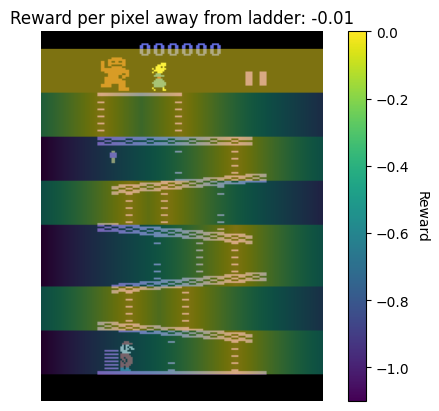

In [133]:
import seaborn as sns

# ------------------
reward_per_dist_to_ladder = -0.01
# ------------------

levels_height = [25, 25, 35, 25, 25, 25, 25]
levels_y_lst = [170, 145, 110, 85, 60, 35, 10]
# ladders_x_coords should match the levels order, assumed defined elsewhere
ladders_x_coords = [[110], [50, 83], [110], [50, 71], [110], [34, 79], []]

# We'll handle the last empty level gracefully.
fig, ax = plt.subplots(figsize=(6.4, 4.8))
ax.imshow(obs)

# Prepare the overlay for distances: set all as np.nan for transparency
overlay = np.full((obs.shape[0], obs.shape[1]), np.nan, dtype=float)

for lvl_idx, lvl_y in enumerate(levels_y_lst):
    y_min = max(0, int(lvl_y))
    y_max = min(obs.shape[0], int(lvl_y + levels_height[lvl_idx]))
    x_min = 0
    x_max = obs.shape[1]
    if lvl_idx >= len(ladders_x_coords):
        ladders_this_level = []
    else:
        ladders_this_level = ladders_x_coords[lvl_idx]
    if len(ladders_this_level) == 0:
        level_dist = np.zeros_like(x, dtype=float)
    else:
        x, y = np.meshgrid(np.arange(x_min, x_max), np.arange(y_min, y_max))
        # For each ladder at this level, compute the distance & take minimum across ladders at each pixel
        distances = []
        for ladder in ladders_this_level:
            distances.append(np.abs(x - ladder))
        # If multiple ladders per level, take the minimum distance per pixel
        level_dist = np.min(distances, axis=0) if len(distances) > 1 else distances[0]
        level_dist = level_dist * reward_per_dist_to_ladder
    overlay[y_min:y_max, x_min:x_max] = np.fmin(
        overlay[y_min:y_max, x_min:x_max], level_dist
    ) if np.any(~np.isnan(overlay[y_min:y_max, x_min:x_max])) else level_dist

# Ensure the color normalization is defined and used consistently for both imshow and colorbar
vmin = np.nanmin(overlay)
vmax = np.nanmax(overlay)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap("viridis")

im = ax.imshow(overlay, cmap=cmap, norm=norm, alpha=0.5)
cbar = ax.figure.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.ax.set_ylabel("Reward", rotation=-90, va="bottom")
ax.axis("off")
ax.set_title(f"Reward per pixel away from ladder: {reward_per_dist_to_ladder}")
plt.show()